In [1]:
outputfolder  = "plots/"
save_plots    = False
inputfilename = "/Users/Gonzalo/github/NEXTdata/Alphas/run3628.dst"

In [2]:
from __future__ import print_function, division

import os
import sys
import time
import glob

import tables            as tb
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions  as coref
import invisible_cities.core.fit_functions   as fitf
import invisible_cities.reco.peak_functions  as pf
import invisible_cities.reco.pmaps_functions as pf
import invisible_cities.reco.tbl_functions   as tbf
import invisible_cities.reco.dst_functions   as dstf

from invisible_cities.reco.params import Correction

pi = np.pi

print("Running on ", time.asctime())

Running on  Fri Apr 14 12:31:38 2017


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8

In [4]:
def load_z_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "Zcorrections")
    return Correction(dst.z.values, dst.factor.values, dst.uncertainty.values)


def load_xy_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "XYcorrections")
    x    = np.unique (dst.x          .values)
    y    = np.unique (dst.y          .values)
    f    = np.reshape(dst.factor     .values, (len(x), len(y)))
    u    = np.reshape(dst.uncertainty.values, (len(x), len(y)))
    return Correction((x,y), f, u)

def load_t_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "Tcorrections")
    return Correction(dst.t.values, dst.factor.values, dst.uncertainty.values)



In [5]:
corrfilename = "/Users/Gonzalo/github/NEXTdata/Alphas/run3628.corr"
zcorr  = load_z_corrections (corrfilename)
xycorr = load_xy_corrections(corrfilename)
tcorr  = load_t_corrections (corrfilename)

In [20]:
dst = dstf.load_dst(inputfilename, "DST", "Events")
dst = dst[dst.nS2 == 1]
dst = dst[dst.R < 150]
dst.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
1,2,1.492019e+09,0,1,350.0,251.357895,1460.681752,552300.0,8.812500,9603.205078,...,654512.5,18,102.2125,102.2125,85.196690,-55.503263,101.681306,-0.577409,8.714130,8.527614
2,3,1.492019e+09,0,1,300.0,248.654160,1424.480923,611050.0,6.043062,17420.824219,...,653562.5,18,42.5125,42.5125,-85.594098,39.492259,94.265520,2.709307,8.428040,8.456854
3,4,1.492019e+09,0,1,300.0,306.161346,1722.519528,474000.0,9.955813,7857.233887,...,655162.5,16,181.1625,181.1625,-142.918068,8.641987,143.179112,3.081198,9.182113,8.241882
4,5,1.492019e+09,0,1,350.0,325.086487,1965.504873,321875.0,10.871688,4010.353027,...,655487.5,11,333.6125,333.6125,2.453711,-124.440975,124.465164,-1.551081,8.089127,7.935277
5,6,1.492019e+09,0,1,325.0,248.712494,1445.254227,552000.0,9.256250,11405.216797,...,654612.5,16,102.6125,102.6125,-70.588768,57.720968,91.183794,2.456147,8.163209,8.283679


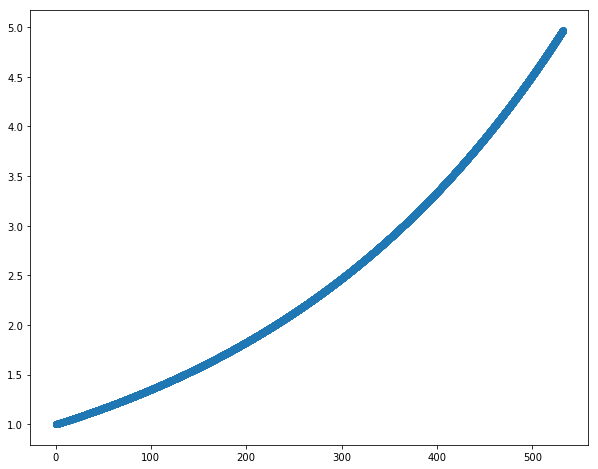

In [13]:
plt.scatter(zcorr.xs, zcorr.fs)

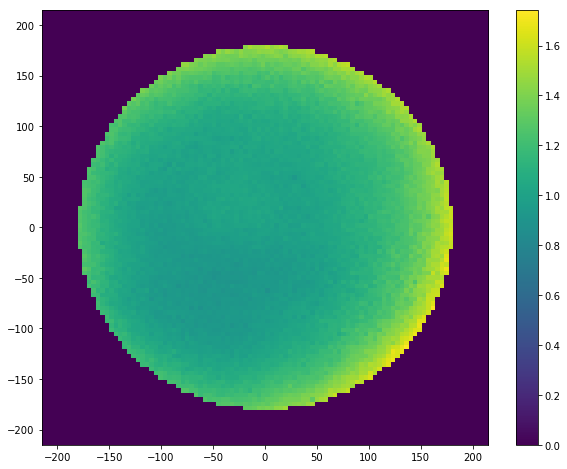

In [14]:
(x, y), e = xycorr.xs.T, xycorr.fs.flatten()
x = np.repeat(x, x.size)
y = np.tile  (y, y.size)

sel = (x**2 + y**2) < 180**2
x = x[sel]
y = y[sel]
e = e[sel]

plt.hist2d(x, y, (100,100), range=((-215,215), (-215,215)), weights=e)
plt.colorbar()

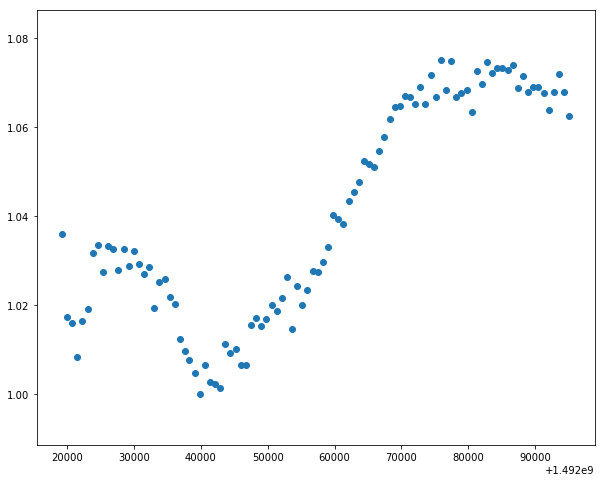

In [15]:
plt.scatter(tcorr.xs, tcorr.fs)

F0: [  1.81315368e+08   1.86207239e+04   5.97363177e+03]
F1: [  3.09096417e+08   5.86314859e+04   8.68634929e+03]
F2: [  2.79351019e+08   6.17726182e+04   4.58841515e+03]
F3: [  2.72165461e+08   6.41648543e+04   4.14876420e+03]


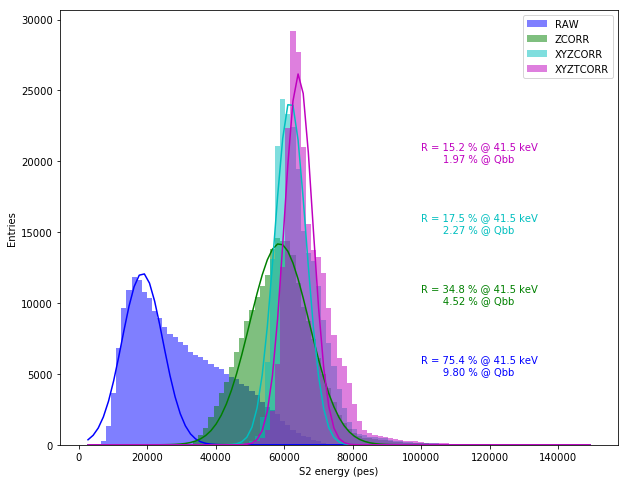

In [18]:
bins = np.linspace(2e3, 150e3, 100)
E = np.array(dst.S2e.values)
plt.figure()
y0, x0, _ = plt.hist(E, bins, label="RAW", alpha=0.5, color="b"); x0 = x0[:-1] + np.diff(x0) * 0.5

E *= zcorr(dst.Z.values)[0]
y1, x1, _ = plt.hist(E, bins, label="ZCORR", alpha=0.5, color="g"); x1 = x1[:-1] + np.diff(x1) * 0.5

E *= xycorr(dst.X.values, dst.Y.values)[0]
y2, x2, _ = plt.hist(E, bins, label="XYZCORR", alpha=0.5, color="c"); x2 = x2[:-1] + np.diff(x2) * 0.5

E *= tcorr(dst.time.values)[0]
y3, x3, _ = plt.hist(E, bins, label="XYZTCORR", alpha=0.5, color="m"); x3 = x3[:-1] + np.diff(x3) * 0.5

m0, m1, m2, m3 = x0[np.argmax(y0)], x1[np.argmax(y1)], x2[np.argmax(y2)], x3[np.argmax(y3)]
f0 = fitf.fit(fitf.gauss, x0, y0, (1e8, m0, 3000), fit_range=(m0 - 10000, m0 + 10000))
f1 = fitf.fit(fitf.gauss, x1, y1, (1e8, m1, 3000), fit_range=(m1 - 10000, m1 + 10000))
f2 = fitf.fit(fitf.gauss, x2, y2, (1e8, m2, 3000), fit_range=(m2 - 10000, m2 + 10000))
f3 = fitf.fit(fitf.gauss, x3, y3, (1e8, m3, 3000), fit_range=(m3 - 10000, m3 + 10000))

plt.plot(x0, f0.fn(x0), "b-")
plt.plot(x1, f1.fn(x1), "g-")
plt.plot(x2, f2.fn(x3), "c-")
plt.plot(x3, f3.fn(x3), "m-")

r0, r1, r2, r3 = 235 * f0.values[2]/f0.values[1], 235 * f1.values[2]/f1.values[1], 235 * f2.values[2]/f2.values[1], 235 * f3.values[2]/f3.values[1]
plt.text(10e4,  5e3, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r0, r0 * (41.5/2458)**0.5), color="b")
plt.text(10e4, 10e3, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r1, r1 * (41.5/2458)**0.5), color="g")
plt.text(10e4, 15e3, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r2, r2 * (41.5/2458)**0.5), color="c")
plt.text(10e4, 20e3, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r3, r3 * (41.5/2458)**0.5), color="m")

plt.legend()

plt.xlabel("S2 energy (pes)")
plt.ylabel("Entries")

print("F0:", f0.values)
print("F1:", f1.values)
print("F2:", f2.values)
print("F3:", f3.values)